# Coursera Capstone

### Expanding into Europe – Zurich District Analysis

In [1]:
# Importing packages
import numpy as np
import pandas as pd
import io
import json

from geopy.geocoders import Nominatim
import requests
from pandas.io.json import json_normalize

import wikipedia as wp

import matplotlib.cm as cm
import matplotlib.colors as colors

from sklearn.cluster import KMeans
from matplotlib import pyplot as plt


import folium

import warnings
warnings.filterwarnings("ignore")

## 1 Scraping and exploring dataset

In [2]:
df_zurich = pd.read_csv("Zurich.csv")
df_zurich

,No.,Latitude,Longitude,MedianRent
0,1,47.370,8.542,525
1,2,47.337,8.521,450
2,3,47.366,8.516,250
3,4,47.375,8.527,320
4,5,47.388,8.521,350
5,6,47.392,8.544,340
6,7,47.373,8.580,360
7,8,47.355,8.561,410
8,9,47.382,8.480,220
9,10,47.407,8.500,240


In [3]:
df_zurich.dtypes

No.             int64
Latitude      float64
Longitude     float64
MedianRent      int64
dtype: object

#### Mapping the Zurich districts

In [6]:
map_studio = folium.Map(location=[47.3769, 8.5417], zoom_start=11)

# add markers to map
for lat, lng, name in zip(df_zurich['Latitude'], df_zurich['Longitude'], df_zurich['No.']):
  label = '{},{}'.format(lng, name)
  label = folium.Popup(label, parse_html=True)
  folium.CircleMarker(
      [lat, lng],
      radius=8,
      popup=label,
      color='blue',
      fill=True,
      fill_color='#3186cc',
      fill_opacity=0.7).add_to(map_studio) 
    
map_studio

#### Exploring District 1

In [7]:
CLIENT_ID = 'AGTX3D1OYQ4PGOU5D0FMM2W2UWJWTDOXVI11WLXY5U5212FW' # my Foursquare ID
CLIENT_SECRET = 'GIHBTALJ1MQOQ1I01MJVF50XPF1GKWEZVBE23ZDQBEXN1JN0' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version
radius = 500
LIMIT = 100

print('Your credentials:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentials:
CLIENT_ID: AGTX3D1OYQ4PGOU5D0FMM2W2UWJWTDOXVI11WLXY5U5212FW
CLIENT_SECRET:GIHBTALJ1MQOQ1I01MJVF50XPF1GKWEZVBE23ZDQBEXN1JN0


#### Getting neighbourhood's latitude and longitude values

In [8]:
district_latitude = df_zurich.loc[0, 'Latitude'] # neighborhood latitude value
district_longitude = df_zurich.loc[0, 'Longitude'] # neighborhood longitude value
district_name = df_zurich.loc[0, 'No.'] # neighborhood name
district_rent = df_zurich.loc[0, "MedianRent" ] # neighborhood name

print('Latitude and longitude values of {} are {}, {}.'.format(district_name, 
                                                               district_latitude, 
                                                               district_longitude))

Latitude and longitude values of 1 are 47.37, 8.542.


#### Getting the top 100 venues that are in District 1 within a radius of 500 meters.

In [9]:
#step 1 - create the correct GET request URL
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    district_latitude, 
    district_longitude, 
    radius, 
    LIMIT)
url # display GET request URL

'https://api.foursquare.com/v2/venues/explore?&client_id=AGTX3D1OYQ4PGOU5D0FMM2W2UWJWTDOXVI11WLXY5U5212FW&client_secret=GIHBTALJ1MQOQ1I01MJVF50XPF1GKWEZVBE23ZDQBEXN1JN0&v=20180605&ll=47.37,8.542&radius=500&limit=100'

#### Sending the GET request to examine the results:

In [10]:
results = requests.get(url).json()
results; # remove ';' to see json data

#### Creating function that extracts the category of the venue:

In [11]:
#
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

#### Cleaning the json and structuring into a pandas dataframe:

In [12]:
venues = results['response']['groups'][0]['items']
    
nearby_venues = json_normalize(venues) # flatten JSON

# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]

# filter the category for each row
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

nearby_venues.head()

,name,categories,lat,lng
0,Sprüngli,Dessert Shop,47.369398,8.539486
1,Frauenbad Stadthausquai,Pool,47.368412,8.542296
2,Zeughauskeller,Swiss Restaurant,47.370250,8.539828
3,barfussbar,Bar,47.368441,8.542181
4,Café Schober,Café,47.371400,8.544149


#### How many venues were returned by Foursquare?

In [13]:
print('{} venues were returned by Foursquare.'.format(nearby_venues.shape[0]))

100 venues were returned by Foursquare.


#### Creating a map  of "District 1" with nearby venues

In [14]:
map_studio = folium.Map(location=[district_latitude, district_longitude], zoom_start=15)

# add markers to map
for lat, lng, name, categories in zip(nearby_venues['lat'], nearby_venues['lng'], nearby_venues['name'], nearby_venues['categories']):
  label = '{},{}'.format(categories,name)
  label = folium.Popup(label, parse_html=True)
  folium.CircleMarker(
      [lat, lng],
      radius=5,
      popup=label,
      color='blue',
      fill=True,
      fill_color='#3186cc',
      fill_opacity=0.7).add_to(map_studio) 
    
map_studio

## 2 Exploring districts in Zurich

#### Creating a function to repeat the same process to all neighbourhoods in Zurich

In [15]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['District', 
                  'District Latitude', 
                  'District Longitude',
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

#### Running the function on each neighbourhood and create a new dataframe "zurich_venues"

In [16]:
zurich_venues = getNearbyVenues(names=df_zurich['No.'],
                                   latitudes=df_zurich['Latitude'],
                                   longitudes=df_zurich['Longitude'],
                                  )

1
2
3
4
5
6
7
8
9
10
11
12


#### Checking the size of the dataframe

In [17]:
print(zurich_venues.shape)
zurich_venues

(405, 7)


,District,District Latitude,District Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,1,47.370,8.542,Sprüngli,47.369398,8.539486,Dessert Shop
1,1,47.370,8.542,Frauenbad Stadthausquai,47.368412,8.542296,Pool
2,1,47.370,8.542,Zeughauskeller,47.370250,8.539828,Swiss Restaurant
3,1,47.370,8.542,barfussbar,47.368441,8.542181,Bar
4,1,47.370,8.542,Café Schober,47.371400,8.544149,Café
5,1,47.370,8.542,Café Milchbar,47.369193,8.540106,Café
6,1,47.370,8.542,Ban Song Thai,47.369467,8.544068,Thai Restaurant
7,1,47.370,8.542,Bindella,47.370618,8.540610,Italian Restaurant
8,1,47.370,8.542,Schwarzenbach Kolonialwaren,47.371444,8.544091,Gourmet Shop
9,1,47.370,8.542,Old Crow,47.372092,8.541024,Cocktail Bar


In [18]:
zurich_venues_1= zurich_venues[['District','Venue','Venue Category']]
zurich_venues_1.head()

,District,Venue,Venue Category
0,1,Sprüngli,Dessert Shop
1,1,Frauenbad Stadthausquai,Pool
2,1,Zeughauskeller,Swiss Restaurant
3,1,barfussbar,Bar
4,1,Café Schober,Café


#### Checking which districts have hotels

In [20]:
zurich_venues_1[zurich_venues_1['Venue Category'].str.contains('Hotel')]

,District,Venue,Venue Category
16,1,Hotel Storchen,Hotel
29,1,Widder Bar,Hotel Bar
32,1,Widder Hotel,Hotel
45,1,Baur au Lac,Hotel
69,1,Savoy Baur en Ville,Hotel
73,1,Marktgasse hotel,Hotel
120,3,Neufeld,Hotel
187,4,Hotel Restaurant Helvetia,Hotel
268,5,Züri by Fassbind,Hotel
283,5,Novotel Zurich City-West,Hotel


#### Checking how many venues were returned for each district

In [21]:
zurich_venues_2 = zurich_venues[['District','Venue']]

In [22]:
zurich_venues_2 = zurich_venues_2.groupby('District').count().head(12)
zurich_venues_2

,Venue
District,
1,100
2,4
3,20
4,100
5,100
6,16
7,8
8,28
9,4


<Figure size 432x288 with 0 Axes>

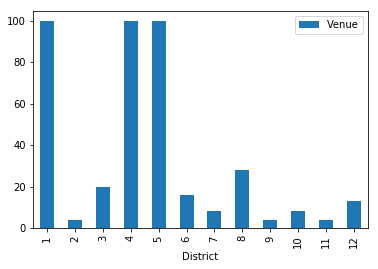

In [23]:
plt.figure()

zurich_venues_2.iloc[0:12].plot(kind='bar');

#### Finding out how many unique categories can be curated from all the returned venues

In [28]:
print('There are {} unique categories.'.format(len(zurich_venues['Venue Category'].unique())))

There are 119 unique categories.


## 3 Analyze each district

In [24]:
# one hot encoding
zurich_onehot = pd.get_dummies(zurich_venues[['Venue Category']], prefix="", prefix_sep="")

# add district column back to dataframe
zurich_onehot['District'] = zurich_venues['District'] 

# move district column to the first column
fixed_columns = [zurich_onehot.columns[-1]] + list(zurich_onehot.columns[:-1])
zurich_onehot = zurich_onehot[fixed_columns]


#### Examining the new dataframe size

In [30]:
zurich_onehot.shape

(405, 120)

#### Grouping rows by district and taking the mean frequency of occurence of each category

In [25]:
zurich_grouped_1 = zurich_onehot.groupby('District').sum().reset_index()
zurich_grouped_1

,District,Accessories Store,Argentinian Restaurant,Art Museum,Arts & Crafts Store,Asian Restaurant,Automotive Shop,Bakery,Bar,Bath House,...,Taverna,Thai Restaurant,Theater,Train Station,Tram Station,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Water Park,Wine Bar,Yoga Studio
0,1,0,1,1,2,0,0,1,5,0,...,0,2,0,0,1,0,0,0,1,0
1,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,3,0,0,0,0,1,0,1,0,0,...,0,1,0,0,0,0,1,0,0,0
3,4,0,0,1,0,0,0,2,14,0,...,0,3,0,0,0,1,2,1,1,1
4,5,1,0,2,0,2,1,3,5,0,...,0,1,1,2,3,0,0,0,0,0
5,6,0,0,0,0,1,0,2,0,0,...,0,0,0,0,1,0,0,0,0,0
6,7,0,0,0,0,0,0,0,1,0,...,0,0,0,0,1,0,0,0,0,0
7,8,0,0,0,0,0,0,2,0,1,...,1,0,0,0,2,0,0,0,0,0
8,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,10,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


In [26]:
zurich_grouped_2 = zurich_grouped_1.filter(['District','Hotel'], axis =1)
zurich_grouped_2.head()

,District,Hotel
0,1,5
1,2,0
2,3,1
3,4,1
4,5,4


In [27]:
zurich_grouped = zurich_onehot.groupby('District').mean().reset_index()
zurich_grouped.head(5)

,District,Accessories Store,Argentinian Restaurant,Art Museum,Arts & Crafts Store,Asian Restaurant,Automotive Shop,Bakery,Bar,Bath House,...,Taverna,Thai Restaurant,Theater,Train Station,Tram Station,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Water Park,Wine Bar,Yoga Studio
0,1,0.00,0.01,0.01,0.02,0.00,0.00,0.01,0.05,0.0,...,0.0,0.02,0.00,0.00,0.01,0.00,0.00,0.00,0.01,0.00
1,2,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,...,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
2,3,0.00,0.00,0.00,0.00,0.05,0.00,0.05,0.00,0.0,...,0.0,0.05,0.00,0.00,0.00,0.00,0.05,0.00,0.00,0.00
3,4,0.00,0.00,0.01,0.00,0.00,0.00,0.02,0.14,0.0,...,0.0,0.03,0.00,0.00,0.00,0.01,0.02,0.01,0.01,0.01
4,5,0.01,0.00,0.02,0.00,0.02,0.01,0.03,0.05,0.0,...,0.0,0.01,0.01,0.02,0.03,0.00,0.00,0.00,0.00,0.00


#### Confirming the new size

In [34]:
zurich_grouped.shape

(12, 120)

#### Printing each district with the top 10 most common venues

In [28]:
num_top_venues = 10

for hood in zurich_grouped['District']:
    print(hood)
    temp = zurich_grouped[zurich_grouped['District'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

1
                venue  freq
0    Swiss Restaurant  0.12
1                Café  0.10
2               Plaza  0.06
3            Boutique  0.05
4               Hotel  0.05
5                 Bar  0.05
6        Cocktail Bar  0.05
7   French Restaurant  0.05
8          Restaurant  0.04
9  Italian Restaurant  0.04


2
                  venue  freq
0    Light Rail Station  0.50
1     Convenience Store  0.25
2           Bus Station  0.25
3  Other Great Outdoors  0.00
4                 River  0.00
5            Restaurant  0.00
6                   Pub  0.00
7             Pool Hall  0.00
8                  Pool  0.00
9                 Plaza  0.00


3
                venue  freq
0          Restaurant  0.15
1  Italian Restaurant  0.10
2                Food  0.05
3         Beer Garden  0.05
4         Pizza Place  0.05
5         Supermarket  0.05
6          Playground  0.05
7         Bus Station  0.05
8       Burrito Place  0.05
9               Diner  0.05


4
                      venue  freq
0     

#### Putting that in a pandas dataframe:

In [29]:
# Writing a function to sort the venues in descending order
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [30]:
#### Creating the new dataframe and displaying the top 10 venues

In [31]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['District']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
districts_venues_sorted = pd.DataFrame(columns=columns)
districts_venues_sorted['District'] = zurich_grouped['District']

for ind in np.arange(zurich_grouped.shape[0]):
    districts_venues_sorted.iloc[ind, 1:] = return_most_common_venues(zurich_grouped.iloc[ind, :], num_top_venues)

districts_venues_sorted

,District,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,1,Swiss Restaurant,Café,Plaza,Cocktail Bar,Boutique,French Restaurant,Bar,Hotel,Italian Restaurant,Restaurant
1,2,Light Rail Station,Convenience Store,Bus Station,Yoga Studio,Gay Bar,Electronics Store,Falafel Restaurant,Farm,Fast Food Restaurant,Food
2,3,Restaurant,Italian Restaurant,Light Rail Station,Playground,Diner,Food,Bus Station,Burrito Place,Lounge,Beer Garden
3,4,Bar,Italian Restaurant,Restaurant,Swiss Restaurant,Café,Thai Restaurant,Coffee Shop,Chinese Restaurant,Nightclub,Pub
4,5,Nightclub,Bar,Restaurant,Café,Hotel,Bakery,Tram Station,Italian Restaurant,Pizza Place,Mexican Restaurant
5,6,Italian Restaurant,Bakery,Bistro,Indian Restaurant,Grocery Store,Middle Eastern Restaurant,Food & Drink Shop,Park,Falafel Restaurant,Coffee Shop
6,7,Bar,Swiss Restaurant,Music Venue,Pool,Tram Station,Golf Course,Skating Rink,Scenic Lookout,Food & Drink Shop,Food
7,8,Swiss Restaurant,Restaurant,Italian Restaurant,Museum,Tram Station,Bakery,Beach,Café,Mexican Restaurant,Coffee Shop
8,9,Middle Eastern Restaurant,Soccer Field,Moving Target,Bus Station,Yoga Studio,Furniture / Home Store,Electronics Store,Falafel Restaurant,Farm,Fast Food Restaurant
9,10,Bus Station,Grocery Store,Wine Bar,Steakhouse,Soccer Field,Other Great Outdoors,Food & Drink Shop,Food Truck,Food Court,Yoga Studio


## 4 Cluster the Districts

#### Running k-means to cluster the districts into 5 clusters

In [32]:
zurich_grouped_clustering = zurich_grouped.drop('District', 1)
zurich_grouped_clustering

,Accessories Store,Argentinian Restaurant,Art Museum,Arts & Crafts Store,Asian Restaurant,Automotive Shop,Bakery,Bar,Bath House,Beach,...,Taverna,Thai Restaurant,Theater,Train Station,Tram Station,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Water Park,Wine Bar,Yoga Studio
0,0.00,0.01,0.01,0.020000,0.000000,0.00,0.010000,0.050,0.000000,0.000000,...,0.000000,0.020000,0.00,0.00,0.010000,0.00,0.00,0.00,0.010,0.00
1,0.00,0.00,0.00,0.000000,0.000000,0.00,0.000000,0.000,0.000000,0.000000,...,0.000000,0.000000,0.00,0.00,0.000000,0.00,0.00,0.00,0.000,0.00
2,0.00,0.00,0.00,0.000000,0.050000,0.00,0.050000,0.000,0.000000,0.000000,...,0.000000,0.050000,0.00,0.00,0.000000,0.00,0.05,0.00,0.000,0.00
3,0.00,0.00,0.01,0.000000,0.000000,0.00,0.020000,0.140,0.000000,0.000000,...,0.000000,0.030000,0.00,0.00,0.000000,0.01,0.02,0.01,0.010,0.01
4,0.01,0.00,0.02,0.000000,0.020000,0.01,0.030000,0.050,0.000000,0.000000,...,0.000000,0.010000,0.01,0.02,0.030000,0.00,0.00,0.00,0.000,0.00
5,0.00,0.00,0.00,0.000000,0.062500,0.00,0.125000,0.000,0.000000,0.000000,...,0.000000,0.000000,0.00,0.00,0.062500,0.00,0.00,0.00,0.000,0.00
6,0.00,0.00,0.00,0.000000,0.000000,0.00,0.000000,0.125,0.000000,0.000000,...,0.000000,0.000000,0.00,0.00,0.125000,0.00,0.00,0.00,0.000,0.00
7,0.00,0.00,0.00,0.000000,0.000000,0.00,0.071429,0.000,0.035714,0.035714,...,0.035714,0.000000,0.00,0.00,0.071429,0.00,0.00,0.00,0.000,0.00
8,0.00,0.00,0.00,0.000000,0.000000,0.00,0.000000,0.000,0.000000,0.000000,...,0.000000,0.000000,0.00,0.00,0.000000,0.00,0.00,0.00,0.000,0.00
9,0.00,0.00,0.00,0.000000,0.000000,0.00,0.000000,0.000,0.000000,0.000000,...,0.000000,0.000000,0.00,0.00,0.000000,0.00,0.00,0.00,0.125,0.00


Text(0.5, 1.0, 'Elbow curve')

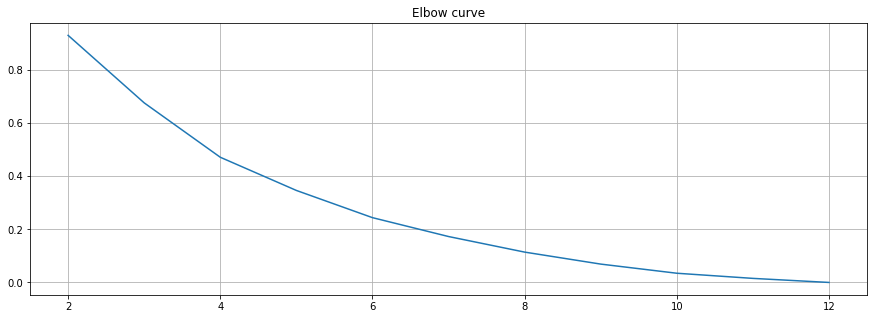

In [33]:
X = zurich_grouped_clustering
distorsions = []
for k in range(2, 13):
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(X)
    distorsions.append(kmeans.inertia_)
    
fig = plt.figure(figsize=(15, 5))
plt.plot(range(2, 13), distorsions)
plt.grid(True)
plt.title('Elbow curve')

In [34]:
# set number of clusters
kclusters = 7

zurich_grouped_clustering = zurich_grouped.drop('District', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(zurich_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:5]

array([3, 2, 3, 3, 3])

#### Creating a new dataframe that includes the cluster as well as the top 10 venues for each district

In [35]:
districts_venues_sorted.insert(0,'Cluster Labels', kmeans.labels_)

zurich_merged = df_zurich

# merge zurich_grouped with zurich_data to add latitude/longitude for each neighbourhood

zurich_merged = zurich_merged.join(districts_venues_sorted.set_index('District'), on='No.')

In [43]:
zurich_merged.drop(['Longitude','Latitude'], axis=1).head(12)

,No.,MedianRent,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,1,525,3,Swiss Restaurant,Café,Plaza,Hotel,French Restaurant,Bar,Boutique,Cocktail Bar,Italian Restaurant,Restaurant
1,2,450,2,Light Rail Station,Convenience Store,Bus Station,Yoga Studio,Gay Bar,Electronics Store,Falafel Restaurant,Farm,Fast Food Restaurant,Food
2,3,250,3,Restaurant,Italian Restaurant,Light Rail Station,Playground,Diner,Food,Bus Station,Burrito Place,Lounge,Beer Garden
3,4,320,3,Bar,Italian Restaurant,Restaurant,Swiss Restaurant,Café,Thai Restaurant,Coffee Shop,Chinese Restaurant,Nightclub,Pub
4,5,350,3,Nightclub,Bar,Restaurant,Café,Hotel,Bakery,Tram Station,Italian Restaurant,Pizza Place,Mexican Restaurant
5,6,340,0,Italian Restaurant,Bakery,Bistro,Indian Restaurant,Grocery Store,Middle Eastern Restaurant,Food & Drink Shop,Park,Falafel Restaurant,Coffee Shop
6,7,360,6,Bar,Swiss Restaurant,Music Venue,Pool,Tram Station,Golf Course,Skating Rink,Scenic Lookout,Food & Drink Shop,Food
7,8,410,3,Swiss Restaurant,Restaurant,Italian Restaurant,Museum,Tram Station,Bakery,Beach,Café,Mexican Restaurant,Coffee Shop
8,9,220,4,Middle Eastern Restaurant,Soccer Field,Moving Target,Bus Station,Yoga Studio,Furniture / Home Store,Electronics Store,Falafel Restaurant,Farm,Fast Food Restaurant
9,10,240,5,Bus Station,Grocery Store,Wine Bar,Steakhouse,Soccer Field,Other Great Outdoors,Food & Drink Shop,Food Truck,Food Court,Yoga Studio


In [36]:
zurich_merged['Cluster Labels'] =zurich_merged['Cluster Labels'].astype(int)

#### Visualizing the resulting clusters

In [43]:
# create map
map_clusters = folium.Map([47.3769, 8.5417], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i+x+(i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(zurich_merged['Latitude'], zurich_merged['Longitude'], zurich_merged['No.'], zurich_merged['Cluster Labels']):
    label = folium.Popup(str(poi)+' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=6,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

## 5. Examine Clusters

#### Cluster 0

In [42]:
zurich_merged.loc[zurich_merged['Cluster Labels']==0,zurich_merged.columns[[0]+list(range(3,zurich_merged.shape[1]))]].head()

,No.,MedianRent,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
5,6,340,0,Italian Restaurant,Bakery,Bistro,Indian Restaurant,Grocery Store,Middle Eastern Restaurant,Food & Drink Shop,Park,Falafel Restaurant,Coffee Shop


#### Cluster 1

In [51]:
zurich_merged.loc[zurich_merged['Cluster Labels']==1,zurich_merged.columns[[0]+list(range(3,zurich_merged.shape[1]))]].head()

,No.,MedianRent,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
10,11,260,1,Farm,Swiss Restaurant,Forest,Bus Station,Yoga Studio,Gay Bar,Eastern European Restaurant,Electronics Store,Falafel Restaurant,Fast Food Restaurant


#### Cluster 2

In [44]:
zurich_merged.loc[zurich_merged['Cluster Labels']==2,zurich_merged.columns[[0]+list(range(3,zurich_merged.shape[1]))]]

,No.,MedianRent,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
1,2,450,2,Light Rail Station,Convenience Store,Bus Station,Yoga Studio,Gay Bar,Electronics Store,Falafel Restaurant,Farm,Fast Food Restaurant,Food


#### Cluster 3

In [45]:
zurich_merged.loc[zurich_merged['Cluster Labels']==3,zurich_merged.columns[[0]+list(range(3,zurich_merged.shape[1]))]]

,No.,MedianRent,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,1,525,3,Swiss Restaurant,Café,Plaza,Cocktail Bar,Boutique,French Restaurant,Bar,Hotel,Italian Restaurant,Restaurant
2,3,250,3,Restaurant,Italian Restaurant,Light Rail Station,Playground,Diner,Food,Bus Station,Burrito Place,Lounge,Beer Garden
3,4,320,3,Bar,Italian Restaurant,Restaurant,Swiss Restaurant,Café,Thai Restaurant,Coffee Shop,Chinese Restaurant,Nightclub,Pub
4,5,350,3,Nightclub,Bar,Restaurant,Café,Hotel,Bakery,Tram Station,Italian Restaurant,Pizza Place,Mexican Restaurant
7,8,410,3,Swiss Restaurant,Restaurant,Italian Restaurant,Museum,Tram Station,Bakery,Beach,Café,Mexican Restaurant,Coffee Shop
11,12,210,3,Arts & Crafts Store,Bus Station,Restaurant,Thai Restaurant,Shopping Mall,Café,Supermarket,Swiss Restaurant,Plaza,Tram Station


#### Cluster 4

In [46]:
zurich_merged.loc[zurich_merged['Cluster Labels']==4,zurich_merged.columns[[0]+list(range(3,zurich_merged.shape[1]))]].head()

,No.,MedianRent,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
8,9,220,4,Middle Eastern Restaurant,Soccer Field,Moving Target,Bus Station,Yoga Studio,Furniture / Home Store,Electronics Store,Falafel Restaurant,Farm,Fast Food Restaurant


#### Cluster 5

In [47]:
zurich_merged.loc[zurich_merged['Cluster Labels']==5,zurich_merged.columns[[0]+list(range(3,zurich_merged.shape[1]))]].head()

,No.,MedianRent,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
9,10,240,5,Bus Station,Grocery Store,Wine Bar,Steakhouse,Soccer Field,Other Great Outdoors,Food & Drink Shop,Food Truck,Food Court,Yoga Studio


#### Cluster 6

In [ ]:
zurich_merged.loc[zurich_merged['Cluster Labels']==5,zurich_merged.columns[[0]+list(range(3,zurich_merged.shape[1]))]].head()